## Maximum Activation

This notebook is adapted from https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/13B_Visual_Analysis_MNIST.ipynb. It allows you to find the input 'image' which would produce the maximum activation for a given filter (or random selection of filters, or all filters) in a given layer of a loaded, pre-trained, U-Net. It also works for whole capsules.

### First, some admin...

In [1]:
# Imports

# This allows us to import directories which are located one level up from this file
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import tensorflow as tf
from keras import layers, models
import numpy as np
import random
import datetime
import math

from SegCaps import capsule_layers
import dataset
import model_functions as mf
import audio_functions as af
import audio_models

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'

Using TensorFlow backend.


In [44]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=16
normalise=True
batch_size = 1
shuffle=False
n_shuffle = 1
mag_phase = True
learning_rate = 0.0002
model_variant = 'unet'
data_type = 'mag'
phase_weight = 0.0005

checkpoint = '234/234-8'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'
#model_base_dir = 'C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Mixed'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Voice'
directory_c = '/home/enterprise.internal.city.ac.uk/acvn728/miniCHiME/Background'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Voice'
#directory_c = 'C:/Users/Toby/MSc_Project/Test_Audio/miniCHiME/Background'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b, directory_c)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
pipe = data.make_initializable_iterator()
mixed_spec, voice_spec, background_spec, mixed_audio, voice_audio, background_audio = pipe.get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
if data_type == 'mag':
    mixed_input = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
    voice_input = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)
elif data_type in ['mag_phase', 'mag_phase_diff']:
    mixed_input = mixed_spec[:, :, :-1, 2:4]
    voice_input = voice_spec[:, :, :-1, 2:4]
elif data_type == 'real_imag':
    mixed_input = mixed_spec[:, :, :-1, 0:2]
    voice_input = voice_spec[:, :, :-1, 0:2]
elif data_type == 'mag_real_imag':
    mixed_input = tf.concat([tf.expand_dims(mixed_spec[:, :, :-1, 2], 3), mixed_spec[:, :, :-1, 0:2]], 3)
    voice_input = tf.concat([tf.expand_dims(voice_spec[:, :, :-1, 2], 3), voice_spec[:, :, :-1, 0:2]], 3)
elif data_type == 'mag_phase_real_imag':
    mixed_input = mixed_spec[:, :, :-1, :]
    voice_input = voice_spec[:, :, :-1, :]
    
data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)>

In [45]:
# Build the required model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_input, voice_input, mixed_phase, mixed_audio, 
                                    voice_audio, background_audio, model_variant, is_training, learning_rate, 
                                    data_type, phase_weight, name='Magnitude_Model')
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(1)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


In [46]:
# Load a saved checkpoint
print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/234/234-8


### Now, the real work ...

This will neatly plot everything when we're done.

In [5]:
def plot_images(images, smooth=True, savepath=None):
    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'
    
    num_cols = 4
    num_rows = int(math.ceil(len(images) / num_cols))
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16,int(num_rows * 2)))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # For each entry in the grid.
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Get the i'th image and only use the desired pixels.
            img = images[i, :, :]

            # Plot the image.
            ax.imshow(img, interpolation=interpolation)

            # Remove ticks.
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            break

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

Functions for getting the names of all the convolutional/capsule layers in the neural network. We could have made this list manually, but for larger neural networks it is easier to do this with a function.

In [6]:
def get_conv_layer_names():
    graph = tf.get_default_graph()
    
    # Create a list of names for the operations in the graph
    # for the Inception model where the operator-type is 'Conv2D'.
    names = [op.name for op in graph.get_operations() if op.type=='Conv2D']

    return names

def get_caps_layer_names():
    # Create a list of names for the operations in the graph
    # for the Inception model where the operator-type is 'Conv2D'.
    names = [op.name for op in graph.get_operations() if op.type=='TensorArrayReadV3']

    return names

This function finds the input image that maximizes a given feature in the network. It essentially just performs optimization with gradient ascent. The image is initialized with small random values and is then iteratively updated using the gradient for the given feature with regard to the image.

In [12]:
def optimize_image(layer_id=None, feature=0,
                   num_iterations=30, show_progress=True, is_capsule=False):
    """
    Find an image that maximizes the feature
    given by the conv_id and feature number.

    Parameters:
    layer_id: Integer identifying the layer to
              maximize. It is an index into layer_names.
              If None then use the last fully-connected layer
              before the softmax output.
    feature: Index into the layer for the feature to maximize.
    num_iteration: Number of optimization iterations to perform.
    show_progress: Boolean whether to show the progress.
    is_capsule: Boolean whether finding the activation of a single convolution or a capsule.
    """

    # Create the loss-function that must be maximized.
    # If no layer is specified, find the max activation image for the output layer
    if layer_id is None:
        layer_name = 'Magnitude_Model/voice-mask-unet/add'
    else:
    # Get the name of the operator for the specified layer.
        if is_capsule:
            layer_names = get_caps_layer_names()
        else:
            layer_names = get_conv_layer_names()
        layer_name = layer_names[layer_id]

    # Get the default TensorFlow graph.
    graph = tf.get_default_graph()

    # Get a reference to the tensor that is output by the
    # operator. Note that ":0" is added to the name for this.
    tensor = graph.get_tensor_by_name(layer_name + ":0")

    # The loss-function is the average of all the
    # tensor-values for the given feature. This
    # ensures that we generate the whole input image.
    # You can try and modify this so it only uses
    # a part of the tensor.
    if is_capsule:
        loss = tf.reduce_mean(tf.norm(tensor, axis=4)[:,:,:,feature])
    else:
        loss = tf.reduce_mean(tensor[:,:,:,feature])

    # Get the gradient for the loss-function with regard to
    # the input image. This creates a mathematical
    # function for calculating the gradient.
    gradient = tf.gradients(loss, mixed_input)

    # Generate a random image of the same size as the raw input.
    # Each pixel is a small random value between 0.45 and 0.55,
    # which is the middle of the valid range between 0 and 1.
    img_shape = tuple(mixed_input.shape.as_list()[1:3])
    image = 0.1 * np.random.uniform(size=img_shape) + 0.45

    # Perform a number of optimization iterations to find
    # the image that maximizes the loss-function.
    for i in range(num_iterations):
        # Reshape the array so it is a 4-rank tensor.
        img_reshaped = image[np.newaxis,:,:,np.newaxis]

        # Create a feed-dict for inputting the image to the graph.
        feed_dict = {model.mixed_input: img_reshaped,
                     model.is_training: False}

        # Calculate the predicted class-scores,
        # as well as the gradient and the loss-value.
        grad, loss_value = sess.run([gradient, loss],
                                     feed_dict=feed_dict)
        
        # Squeeze the dimensionality for the gradient-array.
        grad = np.array(grad).squeeze()

        # The gradient now tells us how much we need to change the
        # input image in order to maximize the given feature.

        # Calculate the step-size for updating the image.
        # This step-size was found to give fast convergence.
        # The addition of 1e-8 is to protect from div-by-zero.
        step_size = 1.0 / (grad.std() + 1e-8)

        # Update the image by adding the scaled gradient
        # This is called gradient ascent.
        image += step_size * grad

        # Ensure all pixel-values in the image are between 0 and 1.
        image = np.clip(image, 0.0, 1.0)

        if show_progress:
            print("Iteration:", i)

            # Print statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))

            # Print the loss-value.
            print("Loss:", loss_value)

            # Newline.
            print()

    return image.squeeze()

In [13]:
def optimize_images(layer_id=0, num_iterations=30, num_filters=None, is_capsule=False):
    """
    Find images that maximize a sub set of filters in the layer
    given by the conv_id.
    
    Parameters:
    layer_id: Integer identifying the convolutional layer to
              maximize. It is an index into layer_names.
              If None then use the output layer.
    num_iterations: Number of optimization iterations to perform.
    num_filters: The number of filters in the given layer to optimise for. If none, use all filters.
    is_capsule: Boolean whether finding the activation of a single convolution or a capsule.
    """

    # Which layer are we using?
    if layer_id is None:
        print("Output layer.")
        layer_name = 'Magnitude_Model/voice-mask-unet/add'
    else:
        if is_capsule:
            layer_names = get_caps_layer_names()
        else:
            layer_names = get_conv_layer_names()
        layer_name = layer_names[layer_id]
        print("Layer:", layer_names[layer_id])

    # Initialize the array of images.
    images = []
    
    # Get number of filters in layer
    graph = tf.get_default_graph()
    tensor = graph.get_tensor_by_name(layer_name + ":0")
    if is_capsule:
        num_filters_in_layer = tensor.shape[-2].value
    else:
        num_filters_in_layer = tensor.shape[-1].value
    
    # If number of filters not specified, assume all are required
    if num_filters is None:
        num_filters = num_filters_in_layer
        filters = np.arange(num_filters)
    else:
        # Randomly select which filters to use
        filters = random.sample(range(num_filters_in_layer), num_filters)
        
    # For each feature do the following.
    for conv_filter in filters:
        print("Optimising image for filter no.", conv_filter)
        
        # Find the image that maximizes the given feature
        # for the network layer identified by conv_id (or None).
        image = optimize_image(layer_id=layer_id, feature=conv_filter,
                               show_progress=False,
                               num_iterations=num_iterations,
                               is_capsule=is_capsule)

        # Squeeze the dim of the array.
        image = image.squeeze()

        # Append to the list of images.
        images.append(image)

    # Convert to numpy-array so we can index all dimensions easily.
    images = np.array(images)
    print('Optimisation complete.')
    
    return images

This cell executes optimisation over multiple layers, for a specified number of filters in each layer.

In [240]:
num_layers = 4
images = np.empty([0,256,512])
for layer in range(num_layers):
    images = np.concatenate((images, optimize_images(layer_id=layer, num_iterations=30, num_filters=None, is_capsule=True)),axis=0)

Layer: Magnitude_Model/voice-mask-unet/Encoder/primarycaps/TensorArrayReadV3
Optimising image for filter no. 0
Optimising image for filter no. 1
Optimisation complete.
Layer: Magnitude_Model/voice-mask-unet/Encoder/conv_cap_2/TensorArrayReadV3
Optimising image for filter no. 0
Optimising image for filter no. 1
Optimising image for filter no. 2
Optimising image for filter no. 3
Optimisation complete.
Layer: Magnitude_Model/voice-mask-unet/Encoder/conv_cap_3/TensorArrayReadV3
Optimising image for filter no. 0
Optimising image for filter no. 1
Optimising image for filter no. 2
Optimising image for filter no. 3
Optimising image for filter no. 4
Optimising image for filter no. 5
Optimising image for filter no. 6
Optimising image for filter no. 7
Optimisation complete.
Layer: Magnitude_Model/voice-mask-unet/Encoder/conv_cap_4/TensorArrayReadV3
Optimising image for filter no. 0
Optimising image for filter no. 1
Optimising image for filter no. 2
Optimising image for filter no. 3
Optimising ima

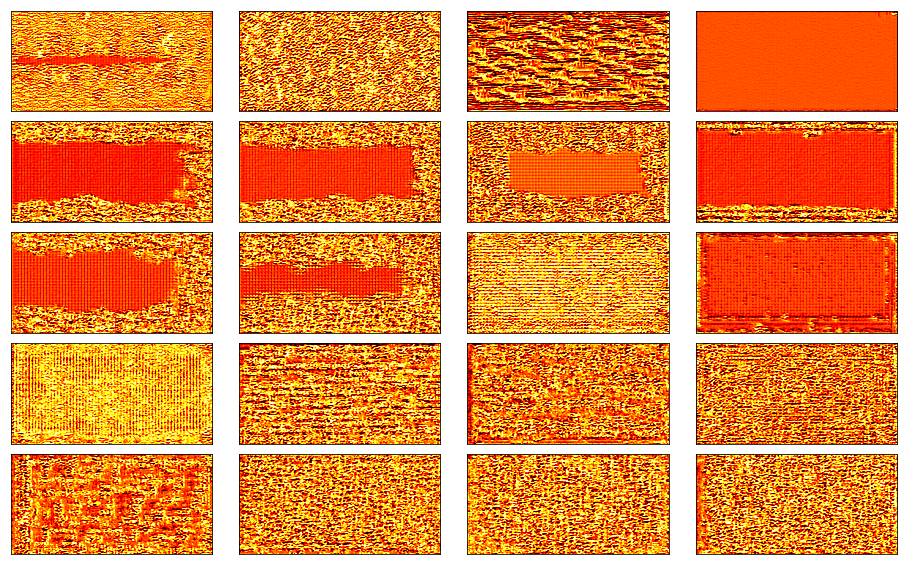

In [250]:
# Plot the images.
savepath = 'Figures/capsunet_capsules_max_activation_l1_3.png'
plot_images(images=images[2:], smooth=True, savepath=savepath)

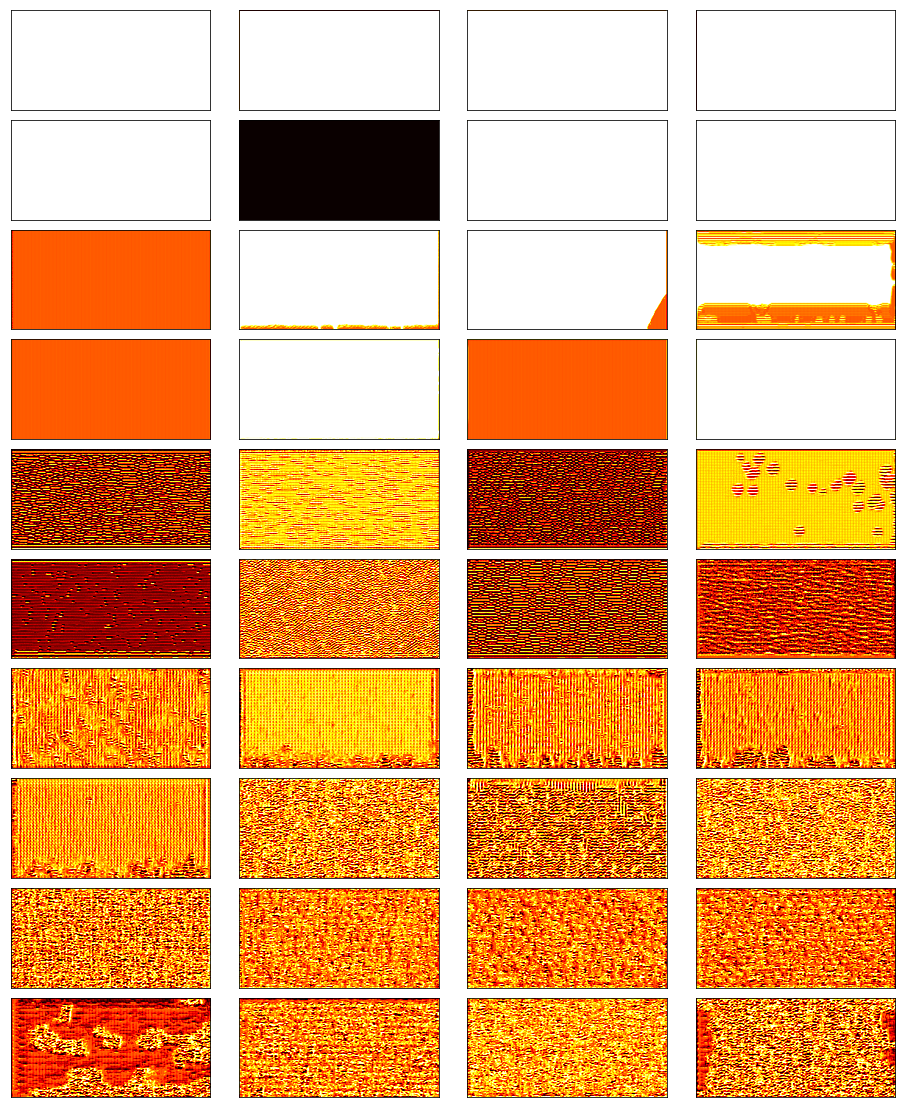

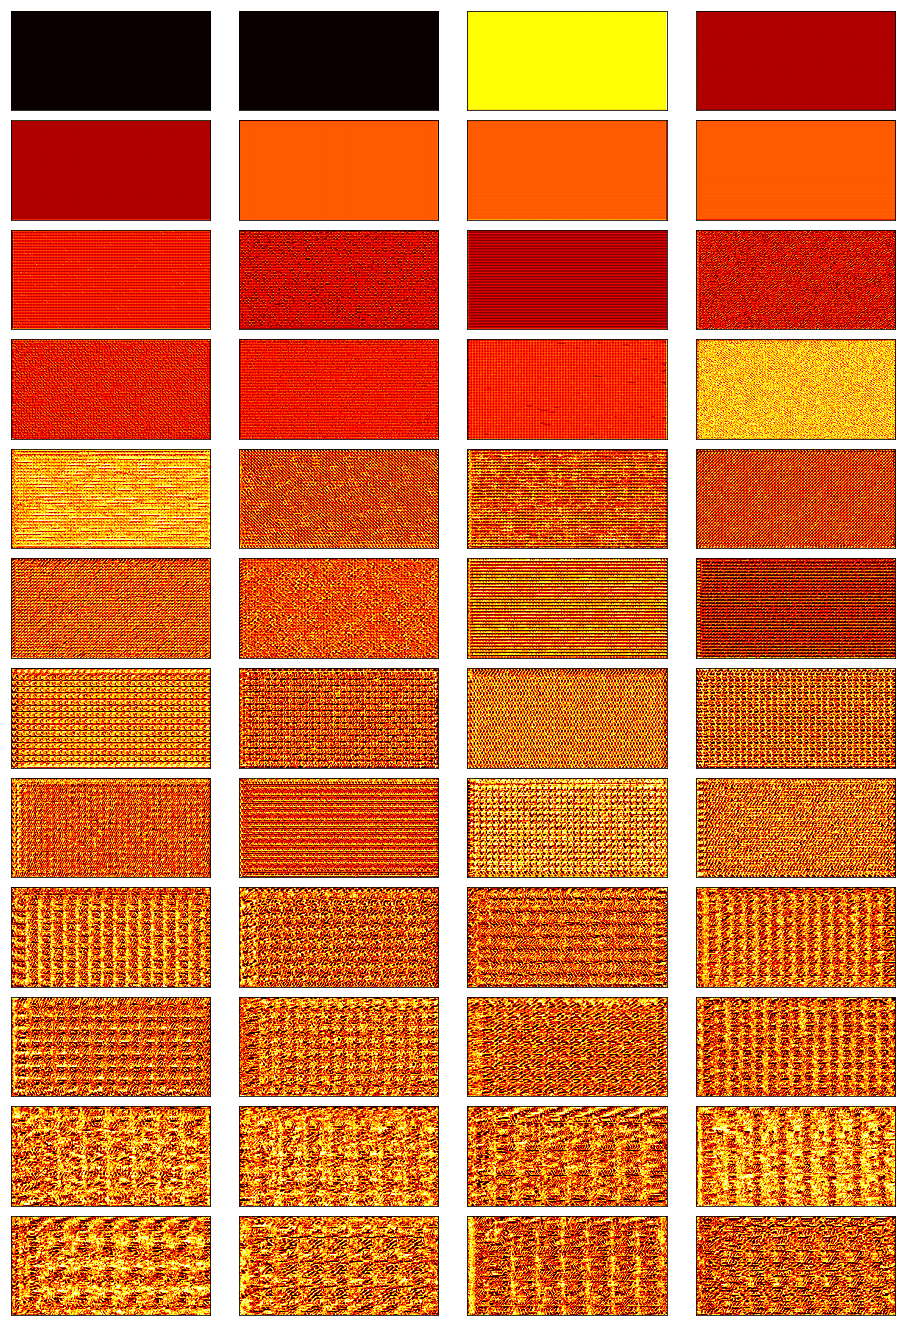

In [54]:
images = optimize_images(layer_id=5, is_capsule=False, num_iterations=30, num_filters=32)

Layer: Magnitude_Model/voice-mask-unet/encoder/layer-6/conv2d/Conv2D
Optimising image for filter no. 118
Optimising image for filter no. 349
Optimising image for filter no. 70
Optimising image for filter no. 446
Optimising image for filter no. 81
Optimising image for filter no. 93
Optimising image for filter no. 80
Optimising image for filter no. 159
Optimising image for filter no. 429
Optimising image for filter no. 325
Optimising image for filter no. 235
Optimising image for filter no. 233
Optimising image for filter no. 69
Optimising image for filter no. 130
Optimising image for filter no. 356
Optimising image for filter no. 239
Optimising image for filter no. 2
Optimising image for filter no. 378
Optimising image for filter no. 160
Optimising image for filter no. 39
Optimising image for filter no. 385
Optimising image for filter no. 275
Optimising image for filter no. 146
Optimising image for filter no. 221
Optimising image for filter no. 390
Optimising image for filter no. 368
Opt

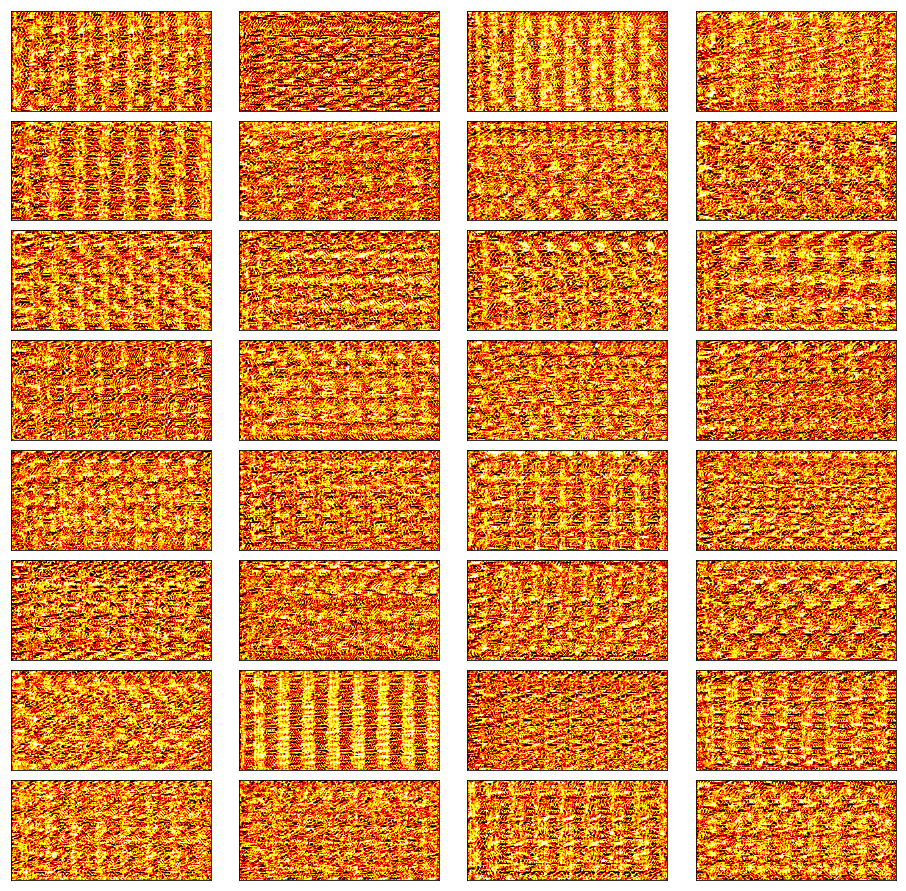

In [55]:
plot_images(images, smooth=True)

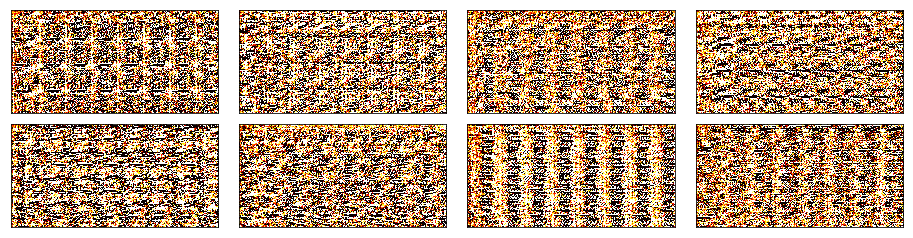

In [209]:
plot_images(images, smooth=False)